# NBA Player Salary Modeling and Analysis

In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specific to model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import joblib

In [3]:
# Import functions/moduls from this project. 
import sys
sys.path.append("../src")

In [4]:
# load cleaned data 
player_data_final = pd.read_csv('../data/player_data_final.csv')

# reproduce test/train splits
X = player_data_final.iloc[:, 1:] 
y = player_data_final.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fine-Tuning the Final Model
Now that we've have the Gradient Boosting Regressor (GBR) as a top-performing model, we'll fine-tune it using an expanded GridSearchCV. After tuning, we'll evaluate the model's accuracy using the holdout test set to see general performance.

In [6]:
# Final model choosen
gbr = GradientBoostingRegressor(random_state=42)

# Expanded param grid, takes a minute
param_grid = {
    'n_estimators': [50, 100, 200],           
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        
    'max_depth': [3, 5, 7, 9],                 
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# pull best model and params
best_gbr = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best R squared score:", grid_search.best_score_)

# Find accuracy on test set
y_pred = best_gbr.predict(X_test)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# print results
print("R squared on Test Set:", r2_test)
print("RMSE on Test Set:", rmse_test) #this is the scaled salary

# Save the fitted model
joblib.dump(best_gbr, '../src/best_gradient_boost_model.joblib')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
Best R squared score: 0.7384125007398259
R squared on Test Set: 0.7084810404163695
RMSE on Test Set: 0.5938595856080378


['../src/best_gradient_boost_model.joblib']

# Questions/Investigations this model can answer:
Here are a few places the model can be leveraged to investigate questions one might have about Player salaries in relation to performance metrics

 - Who are the most underpaid players? overpaid?

 - Which teams consistently have undervalued/overvalued players, this makes for efficient/inefficient roster construction.

 - Investigate whether rookies with strong stats are underpaid due to their contract structures.

We're going to look into the first 2 questions below:


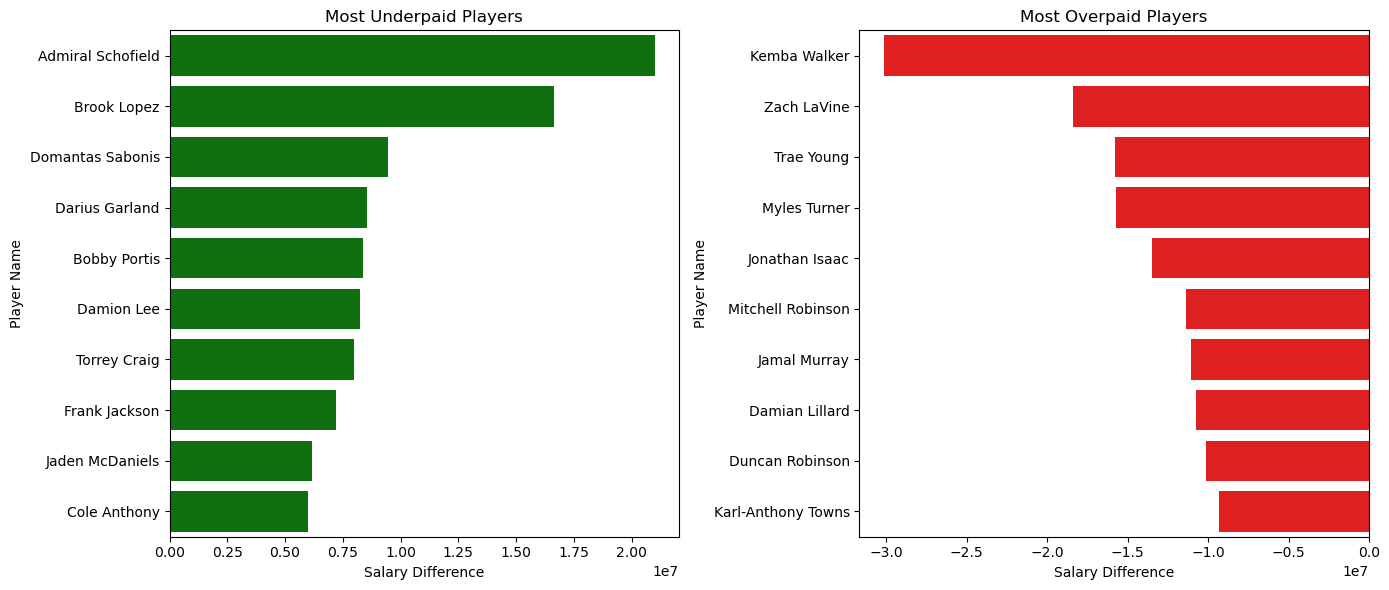

In [8]:
# let's find who is the most underpaid and overpaid players, according to the model

# bring in cleaned/scaled data for predictions
player_data_preds = player_data_final.copy()

# Load original unscaled data
player_data_raw = pd.read_csv('../data/nba_2022-23_all_stats_with_salary.csv')

# Make predictions for every player
player_data_preds['Predicted_Salary_Scaled'] = best_gbr.predict(player_data_preds.drop(['Salary'], axis=1))

# the salary is scaled, so we need to inverse back to dollar values, we'll do this real quick by finding mean and st.dev and apply those back
salary_mean = player_data_raw['Salary'].mean()
salary_std = player_data_raw['Salary'].std()

# inverse the scaling
player_data_raw['Predicted_Salary'] = player_data_preds['Predicted_Salary_Scaled'] * salary_std + salary_mean

# Find the Salary difference between predicted and actual
player_data_raw['Salary Difference'] = player_data_raw['Predicted_Salary'] - player_data_raw['Salary']

# Underpaid/overpaid is just the top and bottom of the list, let's look at the first 10 of each
underpaid = player_data_raw.sort_values('Salary Difference', ascending=False).head(10)
overpaid = player_data_raw.sort_values('Salary Difference').head(10)

# Lets Plot the top/bottom 10
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(y=underpaid['Player Name'], x=underpaid['Salary Difference'], ax=ax[0], color='green')
ax[0].set_title('Most Underpaid Players')
sns.barplot(y=overpaid['Player Name'], x=overpaid['Salary Difference'], ax=ax[1], color='red')
ax[1].set_title('Most Overpaid Players')
plt.tight_layout()
plt.show()

As an NBA fan the above lists passes the vibe check with, generally, older high salary players being overpaid and younger role players being underpaid. Let's take a look at the stats for the top Underpaid/overpaid players

In [10]:
print(overpaid.iloc[0])

Unnamed: 0                        17
Player Name             Kemba Walker
Salary                      37281261
Position                          PG
Age                               32
Team                             DAL
GP                                 9
GS                                 1
MP                              16.0
FG                               2.7
FGA                              6.3
FG%                            0.421
3P                               0.8
3PA                              3.1
3P%                             0.25
2P                               1.9
2PA                              3.2
2P%                            0.586
eFG%                           0.482
FT                               1.9
FTA                              2.3
FT%                             0.81
ORB                              0.3
DRB                              1.4
TRB                              1.8
AST                              2.1
STL                              0.2
B

To add context, this player’s high salary was due to them being in the final year of a long-term contract signed during their prime years, when they were among the league’s best playeres. However, by the 2022–23 season, their performance had declined significantly. Kemba played only a handful of games this season and was out of the NBA after this year. The poor player metrics explains the model's low predicted salary, whiich is why there is a big difference in the actual Salary value and the predicted value.

In [12]:
print(underpaid.iloc[0])

Unnamed: 0                         392
Player Name          Admiral Schofield
Salary                          877940
Position                            PF
Age                                 25
Team                               ORL
GP                                  37
GS                                   0
MP                                12.2
FG                                 1.5
FGA                                3.3
FG%                              0.451
3P                                 0.6
3PA                                2.0
3P%                              0.324
2P                                 0.8
2PA                                1.3
2P%                              0.646
eFG%                             0.549
FT                                 0.6
FTA                                0.6
FT%                              0.913
ORB                                0.6
DRB                                1.1
TRB                                1.7
AST                      

This player's predicted salary is significantly higher than their actual salary, likely due to being on a very small or undrafted contract. It’s unclear why the model assigned such a high prediction here, approximately a starter-level salary despite relatively low metrics. One possible explanation is that the player had strong efficiency metrics (2P%, eFG%, DRB%), which may have influenced the prediction. Further investigation into feature importance would be needed to confirm this.

Now let's look at Which teams consistently have undervalued/overvalued players. To do that we can aggregate the salary difference by team to see which 
pay more/less compared to the predicted aggregations

In [15]:
# as in the cleaning, let's remove anythin with "/" for players traded or waived during the season 
player_data_df_no_trades =  player_data_raw[~player_data_raw['Team'].str.contains('/', regex=False)]

# Group by Team and calculate average salary difference
team_value_efficiency = player_data_df_no_trades.groupby('Team')[['Salary', 'Predicted_Salary', 'Salary Difference']].sum()

# Sort by Salary Difference to see which teams over/under pay the most
team_value_efficiency_sorted = team_value_efficiency.sort_values(by='Salary Difference')

# Top 3 most undervalued and overvalued teams
print("Most undervalued teams:")
print(team_value_efficiency_sorted.tail(3))

print("\nMost overvalued teams:")
print(team_value_efficiency_sorted.head(3))


Most undervalued teams:
         Salary  Predicted_Salary  Salary Difference
Team                                                
PHO   122339923      1.401320e+08       1.779208e+07
ORL    85350819      1.049340e+08       1.958320e+07
MIL   187876425      2.215708e+08       3.369436e+07

Most overvalued teams:
         Salary  Predicted_Salary  Salary Difference
Team                                                
DAL    96150684      6.430971e+07      -3.184098e+07
CHI   103107339      8.283487e+07      -2.027247e+07
NYK   134480498      1.188342e+08      -1.564629e+07


*I knew Dallas had some scrubs that year*

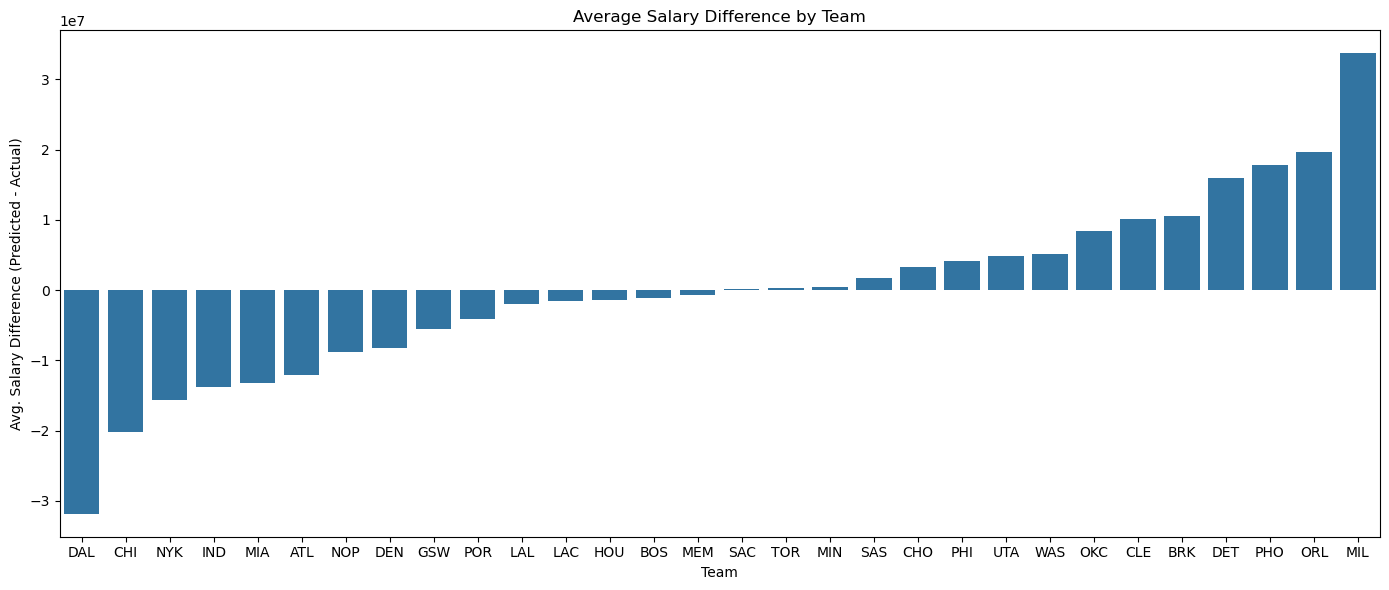

In [17]:
# Let's plot of team value efficiency
plt.figure(figsize=(14, 6))
sns.barplot(x=team_value_efficiency_sorted.index, y=team_value_efficiency_sorted['Salary Difference'])
plt.title('Average Salary Difference by Team')
plt.ylabel('Avg. Salary Difference (Predicted - Actual)')
plt.xlabel('Team')
plt.tight_layout()
plt.show()

# Possible Future Work and enhancements
 - Add multi-season data: bring in multiple years of data could improve generalization and accuracy.

 - Include additional player metrics: Adding more advanced stats such as RAPTOR, or LeBRON, adding award metrics metrics like All-Star appearances, End of Year awards, and adding playoffs metrics could improve predictive power.

- Investigate feature importance and model interpretation to explain predictions.